## Plotting with Soss.jl outputs

In [1]:
using Random
Random.seed!(42)

using ArviZ

# use fancy HTML for xarray.Dataset if available
try
    ArviZ.xarray.set_options(display_style = "html")
catch
    nothing
end

# ArviZ ships with style sheets!
ArviZ.use_style("arviz-darkgrid")

ArviZ is designed to work well with high dimensional, labelled data.
Consider the [eight schools model](https://statmodeling.stat.columbia.edu/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/), which roughly tries to measure the effectiveness of SAT classes at eight different schools.
To show off ArviZ's labelling, I give the schools the names of [a different eight schools](https://en.wikipedia.org/wiki/Eight_Schools_Association).

This model is small enough to write down, is hierarchical, and uses labelling.
Additionally, a centered parameterization causes [divergences](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) (which are interesting for illustration).

First we create our data and set some sampling parameters.

In [2]:
J = 8
y = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]
σ = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]
schools = [
    "Choate",
    "Deerfield",
    "Phillips Andover",
    "Phillips Exeter",
    "Hotchkiss",
    "Lawrenceville",
    "St. Paul's",
    "Mt. Hermon"
]

nwarmup, nsamples, nchains = 1000, 1000, 4;

With Soss, we can define our model for the posterior and easily use it to draw samples from the prior, prior predictive, posterior, and posterior predictive distributions.

First we define our model:

In [3]:
using Soss, NamedTupleTools

mod = Soss.@model (J, σ) begin
    μ ~ Normal(0, 5)
    τ ~ HalfCauchy(5)
    θ ~ Normal(μ, τ) |> iid(J)
    y ~ For(J) do j
        Normal(θ[j], σ[j])
    end
end

constant_data = (J = J, σ = σ)
param_mod = mod(; constant_data...)

Joint Distribution
    Bound arguments: [J, σ]
    Variables: [τ, μ, θ, y]

@model (J, σ) begin
        τ ~ HalfCauchy(5)
        μ ~ Normal(0, 5)
        θ ~ Normal(μ, τ) |> iid(J)
        y ~ For(J) do j
                Normal(θ[j], σ[j])
            end
    end


Then we draw from the prior and prior predictive distributions.
We will store the outputs in `MonteCarloMeasurements.Particles`.

In [4]:
prior_prior_pred = map(1:nchains*nsamples) do _
    draw = rand(param_mod)
    return delete(draw, keys(constant_data))
end
prior = map(draw -> delete(draw, :y), prior_prior_pred)
prior_pred = map(draw -> delete(draw, (:μ, :τ, :θ)), prior_prior_pred);

Next, we draw from the posterior using [DynamicHMC.jl](https://github.com/tpapp/DynamicHMC.jl).

In [5]:
post = map(1:nchains) do _
    dynamicHMC(param_mod, (y = y,), nsamples)
end;

Finally, we use the posterior samples to draw from the posterior predictive distribution.

In [6]:
pred = predictive(mod, :μ, :τ, :θ)
post_pred = map(post) do post_draws
    map(post_draws) do post_draw
        pred_draw = rand(pred(post_draw)(constant_data))
        return delete(pred_draw, keys(constant_data))
    end
end;

Each Soss draw is a `NamedTuple`.
Now we combine all of the samples to an `InferenceData`:

In [7]:
idata = from_namedtuple(
    post;
    posterior_predictive = post_pred,
    prior = [prior],
    prior_predictive = [prior_pred],
    observed_data = Dict("y" => y),
    constant_data = constant_data,
    coords = Dict("school" => schools),
    dims = Dict(
        "y" => ["school"],
        "σ" => ["school"],
        "θ" => ["school"],
    ),
    library = Soss,
)

InferenceData with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data
	> constant_data

We can compare the prior and posterior predictive distributions:

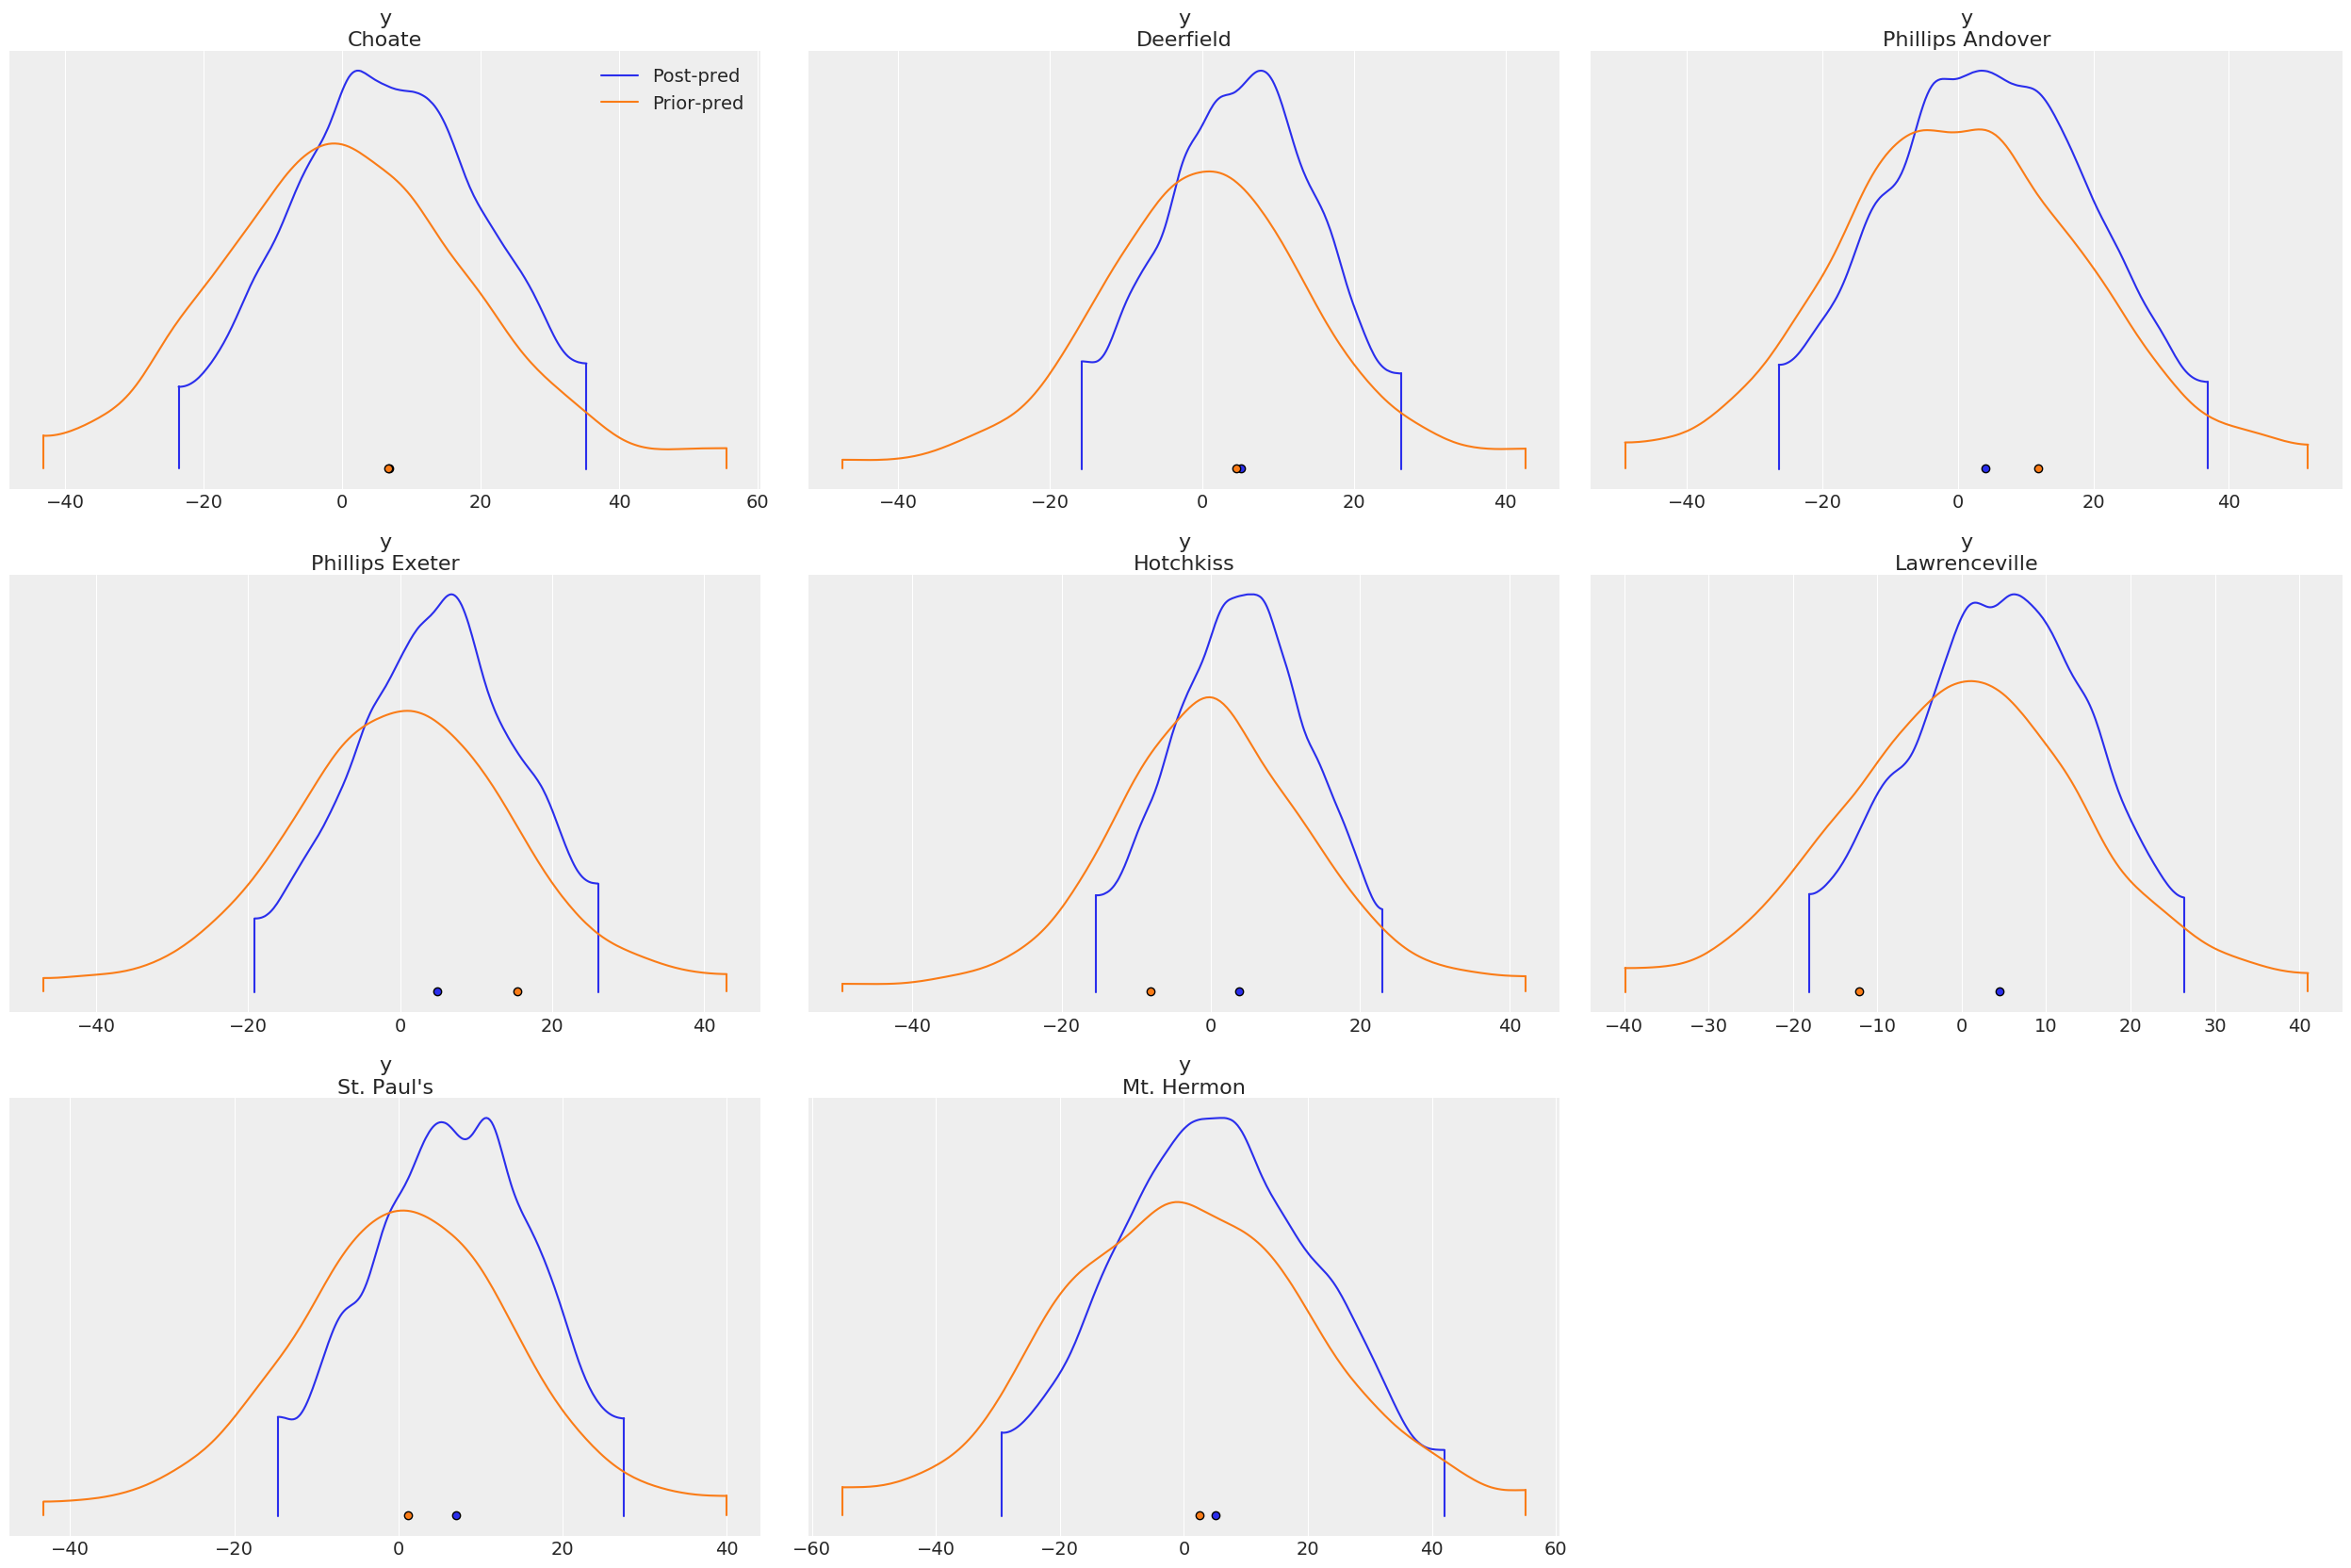

In [8]:
plot_density(
    [idata.posterior_predictive, idata.prior_predictive];
    data_labels = ["Post-pred", "Prior-pred"],
    var_names = ["y"],
);

## Environment

In [9]:
using Pkg
Pkg.status()

    Status `~/projects/ArviZ.jl/examples/Project.toml`
  [131c737c] ArviZ v0.2.5 #master (https://github.com/arviz-devs/ArviZ.jl.git)
  [593b3428] CmdStan v6.0.2
  [31c24e10] Distributions v0.21.12
  [7073ff75] IJulia v1.21.1
  [c7f686f2] MCMCChains v1.0.2
  [d9ec5142] NamedTupleTools v0.12.1
  [8ce77f84] Soss v0.10.0
  [fce5fe82] Turing v0.8.2


In [10]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_CMDSTAN_HOME = /Users/saxen/projects/cmdstan-2.18.0


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*